# Introduction
In this study, we will start by studying the applicability of using the raw data from the seismometer as an input to the neural network for recognition and prediction of earthquakes. The raw data is a time series data of 100 Hz frequency which discribes the vertical motion of the earth. The figure below show a simple illustration of how it is measured. Note that the current tools rely on a more sophisticated and accurate tools but the concept is still the same.

As mentioned above, two problems are studied described in the figure above. Obviously, the second problem is more complicated as there is no known method to do this. In fact, it is not known that the signal contain information for the prediction. The two problems are:
1. The recognition of the earthquakes signal after they occur.
2. The prediction of earthquakes signal before they occur.

<img src="Figures/For Notbooks/Seismometer.png" width="700">

# Dataset
The dataset was harvested from servers specifically for this study. After compiling numerous datasets with varying [minimum earthquake magnitude](https://en.wikipedia.org/wiki/Richter_magnitude_scale), lateral coverage, and number of stations, this study area ([The Geysers](https://en.wikipedia.org/wiki/The_Geysers)) of the  is specifically chosen because:
1. It contains a spatially dense seismometers coverage.
2. The seismicmometers have been operating for a relatively long time.
3. The area is tectonically active because of the existance of the geysers.
4. Enhanced geothermal system are operating in the area creating more earthquakes.

<img src="Figures/For Notbooks/Map.png" width="600">


# Package and helper functions
We will use [Keras](https://keras.io/) to build the neural network, [Matplotlib](https://matplotlib.org/) for plotting results if needed, and [Numpy](http://www.numpy.org/) for matrix manipulation.

In [50]:
# Basic packages
import numpy as np
import matplotlib.pyplot as plt

# Keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Flatten, MaxPooling1D
from keras.optimizers import Adam

# Sklearn
from sklearn.metrics import confusion_matrix

We will use this cell to create some helper functions that will be used in the analysis. We decided to have all the functions needed in one script to facilitate readibility and understanding.

In [51]:
def splitDataset1D(X, Y, proportions=np.array([.8, .2])):
    """
    Splits the dataset into a number of smaller datasets with certain given ratios.
    
    Argument:
    X -- Input dataset
    Y -- Labels

    Returns:
    Xs -- Splitted dataset (dictionary with numbers as keys)
    Ys -- Splitted labels  (dictionary with numbers as keys)
    """
    
    # Make sure proportions are a numpy array
    proportions = np.array(proportions)
    
    # Handle an option to provide one ratio
    if (np.sum(proportions)!=1):
        ratios = np.concatenate((proportions, np.array([1-np.sum(proportions)])))

    # Create the random indices
    m = X.shape[1] 
    randomIndecies = np.random.permutation(m)
    
    # Calculate the number of boundaries of indecies in each set
    nSamples = np.round(np.array(proportions) * m)
    nSamples = np.concatenate((np.array([0]), np.round(proportions * m)))
    nSamples = np.cumsum(nSamples)
    nSamples = nSamples.astype(int)
    
    # Extract teh sets
    Xs = []
    Ys = []
    for i in range(0, proportions.size):
        chosenSamples = randomIndecies[nSamples[i]:nSamples[i+1]]
        Xs.append(X[:, chosenSamples, :])
        Ys.append(Y[chosenSamples, :])
        
    return Xs, Ys

# ======================================================================
def normalizeData(data, axis=None, keepdims=True):
    """
    Computes the zscore of data along a certain axis.
    
    Argument:
    data -- Data to be normalized
    axis -- Axis to normalized (if no axis is given, we

    Returns:
    normalizedData -- normalized dataset
    Ys -- Splitted labels  (dictionary with numbers as keys)
    """
    
    # Zscore normalization
    normalizedData = (data - np.mean(data, axis = axis, keepdims= keepdims)) / np.std(data, axis = axis, keepdims = keepdims)
    return normalizedData

# ======================================================================
def plotAccuracy(history, isError=True):
    trainValues = np.array(history.history["acc"])
    validValues = np.array(history.history["val_acc"])
    
    if (isError == True):
        trainValues = 1-trainValues
        validValues = 1-validValues
    
    trainAxe, = plt.plot(trainValues, label="Training set")
    validAxe, = plt.plot(validValues, label="Validation set")
    
    if (isError == True):
        plt.ylabel('Error (fraction)')
    else:
        plt.ylabel('Accuracy (fraction)')

    plt.xlabel('Epoch')
    
    plt.legend(handles=[trainAxe, validAxe])


# Dataset

Now, we will load the dataset. The dataset is already saved in binary numpy format using another script written specifically for this study. The data loaded is the time series data and the labels. Note that we have two datasets.

In [56]:
folderName = "Datasets"
datasetNumber = 9
testPercent = .1

data = np.load(folderName + "\Data_D" + str(datasetNumber) + ".npy")
label = np.load(folderName + "\Label_D" + str(datasetNumber) + ".npy")

# for recognition dataset (12,13,14)
if (datasetNumber == 12 or datasetNumber == 13 or datasetNumber == 14):
    data = data[25000:35000,:,:]

# for prediction dataset (9,10,11)
if (datasetNumber == 9 or datasetNumber == 10 or datasetNumber == 11):
    data = data[29500:30000,:,:]

# Calculate the training percentage
trainingPercent = 1 - testPercent;

# Normalize the dataset
data = normalizeData(data, axis=1)

# Split the dataset
Xs, Ys = splitDataset1D(data, label, proportions=[trainingPercent, testPercent])

xTrain = np.swapaxes(Xs[0],0,1)
xTest = np.swapaxes(Xs[1],0,1)

yTrain = Ys[0][:,0]
yTest = Ys[1][:,0]

# Neural network model

The model that will be used for this 1D convolutional network is as discribed in the figure.

In [53]:
def constructModel(inputShape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    xInput = Input(shape = inputShape)
    
    X = Conv1D(8, kernel_size=4, strides=1, dilation_rate=1)(xInput)       
    X = MaxPooling1D(pool_size=2, strides=None, padding='same')(X)
    X = BatchNormalization()(X)                                          
    X = Activation('relu')(X)                                              
    X = Dropout(.05)(X)                                                  

    X = Conv1D(16, kernel_size=4, strides=1, dilation_rate=2)(X)       
    X = MaxPooling1D(pool_size=2, strides=None, padding='same')(X)
    X = BatchNormalization()(X)                          
    X = Activation('relu')(X)                             
    X = Dropout(.05)(X)                                  

    X = Conv1D(32, kernel_size=4, strides=1, dilation_rate=2)(X)    
    X = MaxPooling1D(pool_size=2, strides=None, padding='same')(X)
    X = BatchNormalization()(X)                            
    X = Activation('relu')(X)                             
    X = Dropout(.05)(X)                                 
    
    X = Flatten()(X)
    X = Dense(1, activation = "sigmoid")(X) 

    model = Model(inputs = xInput, outputs = X)
    
    return model

model = constructModel(inputShape = (xTrain.shape[1], 1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1000, 1)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 997, 8)            40        
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 499, 8)            0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 499, 8)            32        
_________________________________________________________________
activation_49 (Activation)   (None, 499, 8)            0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 499, 8)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 493, 16)           528       
__________

# Training the model

In [54]:
model = constructModel(inputShape = (xTrain.shape[1], 1))
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
history = model.fit(xTrain, yTrain, batch_size = 256, epochs=40,  validation_split=.2)

Train on 2577 samples, validate on 645 samples
Epoch 1/40
2577/2577 [==============================] - 6s 2ms/step - loss: 0.6995 - acc: 0.5367 - val_loss: 0.6842 - val_acc: 0.5659
Epoch 2/40
2577/2577 [==============================] - 3s 986us/step - loss: 0.7030 - acc: 0.5537 - val_loss: 0.6837 - val_acc: 0.5488
Epoch 3/40
2577/2577 [==============================] - 2s 957us/step - loss: 0.7161 - acc: 0.5320 - val_loss: 0.6819 - val_acc: 0.5659
Epoch 4/40
2577/2577 [==============================] - 2s 965us/step - loss: 0.6947 - acc: 0.4913 - val_loss: 0.6835 - val_acc: 0.4992
Epoch 5/40
2577/2577 [==============================] - 2s 967us/step - loss: 0.7036 - acc: 0.5530 - val_loss: 0.6893 - val_acc: 0.5659
Epoch 6/40
2577/2577 [==============================] - 2s 967us/step - loss: 0.6900 - acc: 0.5537 - val_loss: 0.6871 - val_acc: 0.5581
Epoch 7/40
2577/2577 [==============================] - 2s 953us/step - loss: 0.6899 - acc: 0.5386 - val_loss: 0.6893 - val_acc: 0.5659
Epo

358/358 [==============================] - 0s 302us/step
Test set accuracy =  0.5418994416737689
Guess Accuracy =  0.5332402234636872
[[0.51675978 0.0027933 ]
 [0.45530726 0.02513966]]


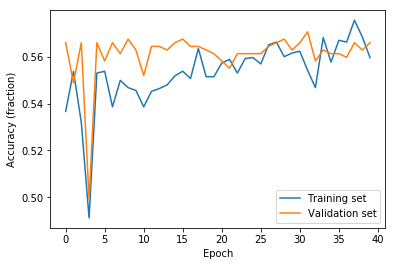

In [55]:
loss, acc = model.evaluate(xTest, yTest)
print("Test set accuracy = ", acc)
print("Guess Accuracy = ", 1-np.sum(label)/label.size)

yPred = model.predict(xTest) > .5                      
print(confusion_matrix(yTest, yPred)/yTest.size)

plotAccuracy(history, False)